# Machine Learning Lab 2

## Assignment 3 (Deadline : 08/02/2023 11:59PM)

Total Points : 25

Your answers must be entered in LMS by midnight of the day it is due. 

If the question requires a textual response, you can create a PDF and upload that. 

The PDF might be generated from MS-WORD, LATEX, the image of a hand- written response, or using any other mechanism. 

Code must be uploaded and may require demonstration to the TA. 

Numbers in the parentheses indicate points allocated to the question. 

**Naming Convention**: FirstName_LastName_Lab3_TLP23.ipynb

**Assignment**: 3-class Sentiment Analysis with LSTM on Twitter Data
 

**Objective**:
The objective of this assignment is to train a LSTM neural network to perform 3-class sentiment analysis on Twitter data.
 

**Dataset**:
The dataset used in this assignment is the Sentiment140 dataset, which can be downloaded from http://help.sentiment140.com/for-students. The dataset consists of 1.6 million tweets, labeled as positive (4), neutral (2), or negative (0)

In [1]:
from google.colab import drive

drive.mount('/content/gdrive/', force_remount=False)

Mounted at /content/gdrive/


In [2]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 20.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 102.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 26.7 MB/s eta 0:00:00


#Importing Libraries

In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
import random
import gc

# Remove warnings
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
%matplotlib inline

#Regex
import re

#for removing html tags
from html.parser import HTMLParser

#important libraries for preprocessing using NLTK
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
nltk.download(['stopwords','omw-1.4'])

#importing libraries for model creation
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Conv1D, Embedding, Bidirectional, SpatialDropout1D
from tensorflow.keras import losses

#importing classification report for reporting accuracy, precision, recall and F1 score
from sklearn.metrics import classification_report

# Importing the pipeline module
from transformers import pipeline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


*   Collect a sample of at least 50,000 tweets from the dataset **(1 points)**

#Loading Data

Merging all 13 files(2 tsv and 11 csv) into one data frame having 53368 tweets

In [4]:
Train = pd.DataFrame()
for i in range(1,14,1):
  if i<3:
    x = pd.read_csv(f'/content/gdrive/MyDrive/Colab Notebooks/ML2 Lab 3/{i}.tsv',sep='\t',names=['ID','t_id','Polarity','Tweet'])
    x.drop(['t_id','ID'],axis=1,inplace=True)
  else:
    x = pd.read_csv(f'/content/gdrive/MyDrive/Colab Notebooks/ML2 Lab 3/{i}.txt',sep='\t',names=['ID','Polarity','Tweet','O'])
    x.drop(['ID','O'],axis=1,inplace=True)
  Train = pd.concat([Train,x],axis=0)
# /content/gdrive/MyDrive/Colab Notebooks/ML2 Lab 3/1.tsv

In [5]:
Train = Train.reset_index()
Train.drop('index',axis=1,inplace=True)

In [6]:
Train.head()

,Polarity,Tweet
0,negative,"I know I missed something here , but what does..."
1,neutral,What do you think of Beside Ourselves as a tit...
2,positive,:D I intend to be one someday .
3,negative,LLLINKKK LLLINKKK IIIMAGEEELLLINKKK The choice...
4,neutral,LLLINKKK Some more mountains .


In [7]:
Train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53368 entries, 0 to 53367
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Polarity  53368 non-null  object
 1   Tweet     53368 non-null  object
dtypes: object(2)
memory usage: 834.0+ KB


In [8]:
Test = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/ML2 Lab 3/testdata.manual.2009.06.14.csv',names=['Polarity','t_id','time','version','user','Tweet'])
Test.drop(['t_id','time','version','user'],axis=1,inplace=True)

In [9]:
Test.head()

,Polarity,Tweet
0,4,@stellargirl I loooooooovvvvvveee my Kindle2. ...
1,4,Reading my kindle2... Love it... Lee childs i...
2,4,"Ok, first assesment of the #kindle2 ...it fuck..."
3,4,@kenburbary You'll love your Kindle2. I've had...
4,4,@mikefish Fair enough. But i have the Kindle2...


#Data Preprocessing

*   Preprocess the text data by removing punctuation, lowercasing, removing stop words, and tokenizing the words **(3 points)**

Resources: 
1. Twitter Data Cleaning Article - https://towardsdatascience.com/basic-tweet-preprocessing-in-python-efd8360d529e
2. Twitter Data Cleaning (geeksforgeeks) - https://www.geeksforgeeks.org/python-efficient-text-data-cleaning/
3. Regular Expressions -  https://www3.ntu.edu.sg/home/ehchua/programming/howto/Regexe.html 
4. Alex's notebook for text cleaning - https://github.com/afo/data-x-plaksha/blob/master/07a-tools-nlp-basics/notebook-nlp-sentiment-analysis-imdb-afo_v2.ipynb

1. Removal of URLs 
2. Lower casing
3. Removal of Punctuations
4. Removal of Stopwords
5. Stemming
6. Removal of HTML tags

In [10]:
ps = PorterStemmer()
url_pattern = re.compile(r'https?://\S+|www\.\S+')
eng_stopwords = stopwords.words('english')
eng_stopwords.remove('not') #'not' is removed from the stopword list as may carry a negative sentiment
eng_stopwords.remove('very')  #Similarly, 'very' is removed as it may deepen the sentiment
#Removing the below two words as these two words are used for url links of images/articles,etc.
eng_stopwords.append('lllinkkk')  
eng_stopwords.append('iiimageeelllinkkk')

In [12]:
def preprocessing_text(text):

  text = url_pattern.sub(r'', text) #Removing urls using url_pattern
  text = text.lower() #Lower casing all the text
  text = re.sub('[^a-z]',' ',text)  #Removing special characters
  text = re.sub('@[^\s]+',' ',text)  #Removing twitter handles
  # print(text)
  #Using stemming
  '''
  Stemming is the process of producing morphological variants of a root/base word.
  '''
  sentence = ''
  word_c = ''
  for word in text.split():
    # print(word)
    if word not in eng_stopwords:
      word_c = word #Stopwords are filtered...
      word_c = ps.stem(word_c)  #Stemming is in progress...
      sentence+=word_c+' '   

  return sentence

Removing HTML Tags

In [13]:
def clean_df(df):
   
  df = HTMLParser().unescape(df)
  for i,text in enumerate(df):
    df[i] = preprocessing_text(text)

  return df

Cleaned data frame of Train data

In [14]:
Train['Tweet'] = clean_df(Train['Tweet'])

In [15]:
Train.head()

,Polarity,Tweet
0,negative,know miss someth thud mean
1,neutral,think besid titl
2,positive,intend one someday
3,negative,choic take rocki put death row
4,neutral,mountain


Removing tweets with no text

In [16]:
def clean_nulldf(df):
  df['Tweet'][df['Tweet']=='']=float('nan')
  df.dropna(inplace=True)
  df.reset_index(inplace=True)
  df.drop('index',axis=1,inplace=True)
  
  return df

In [17]:
Train = clean_nulldf(Train)

In [18]:
print(f'Shape of Train data: {Train.shape}')

Shape of Train data: (53364, 2)


In [19]:
Train.head(10)

,Polarity,Tweet
0,negative,know miss someth thud mean
1,neutral,think besid titl
2,positive,intend one someday
3,negative,choic take rocki put death row
4,neutral,mountain
5,positive,still yo friend grrrrl
6,positive,wait ill dress love
7,negative,snakiest peopl face planet
8,negative,not villain wager
9,negative,could not taken pic w look dead face


#Data Preparation

*   Split the data into training and testing sets, and pad the sequences to the same length **(2 points)** 

(Splitting is carried out in the model while training)

Resource: <br>
https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization


tf.keras.layers.TextVectorization for data standardization, tokenization, and vectorization.

The processing of each example contains the following steps:

1. Standardize each example (usually lowercasing + punctuation stripping)<br>
2. Split each example into substrings (usually words)
3. Recombine substrings into tokens (usually ngrams)
4. Index tokens (associate a unique int value with each token)
5. Transform each example using this index, either into a vector of ints or a dense float vector.

**Tokenization** refers to splitting strings into tokens (for example, splitting a sentence into individual words by splitting on whitespace).

Converting words to vectors, or **word vectorization**, is a natural language processing (NLP) process. The process uses language models to map words into vector space. A vector space represents each word by a vector of real numbers. It also allows words with similar meanings have similar representations.

In [20]:
Train_data = tf.data.Dataset.from_tensor_slices(Train['Tweet'])
max_features = 10000  # Maximum vocab size.
max_len = 10  # Sequence length to pad the outputs to.

# Create the layer.
vectorize_layer = tf.keras.layers.TextVectorization(
 max_tokens=max_features,
 output_mode='int',
 output_sequence_length=max_len)

# Now that the vocab layer has been created, call `adapt` on the
# text-only dataset to create the vocabulary. You don't have to batch,
# but for large datasets this means we're not keeping spare copies of
# the dataset.
vectorize_layer.adapt(Train_data.batch(64))


# Create the model that uses the vectorize text layer
model_vec = tf.keras.models.Sequential()

# Start by creating an explicit input layer. It needs to have a shape of
# (1,) (because we need to guarantee that there is exactly one string
# input per batch), and the dtype needs to be 'string'.
model_vec.add(tf.keras.Input(shape=(1,), dtype=tf.string))

# The first layer in our model is the vectorization layer. After this
# layer, we have a tensor of shape (batch_size, max_len) containing
# vocab indices.
model_vec.add(vectorize_layer)

X_train = model_vec.predict(Train['Tweet']) #Train['Tweet] - Preprocessed data 

1668/1668 [==============================] - 4s 2ms/step


In [21]:
vocab_size = vectorize_layer.vocabulary_size()

In [22]:
X_train.shape

(53364, 10)

In [23]:
y_train = pd.get_dummies(Train['Polarity'])
y_train = np.array(y_train)

In [24]:
y_train.shape

(53364, 3)

In [25]:
polarity_train = set(Train['Polarity'])

In [26]:
print(f'Shape of Train data: {X_train.shape} and polarity values are {polarity_train}')
# print(f'Shape of Test data: {Test.shape} and Unique values{polarity_test}')

Shape of Train data: (53364, 10) and polarity values are {'negative', 'neutral', 'positive'}


#Model Building

*   Build a LSTM model to classify the tweets as positive, neutral, or negative. The model should have an Embedding layer, followed LSTM layers of your choosing, and a dense layer for output **(7 points)**

*   Fine-tune the model by experimenting with different architectures, optimizers, activation functions, and hyperparameters. Feel free to experiment with GRUs **(4 points)**

In [27]:
random.seed(42)
embedding_dim = 32
model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_len,mask_zero=True),
        tf.keras.layers.LSTM(64, return_sequences=True, dropout=0.3, recurrent_dropout=0.25),
        # tf.keras.layers.SpatialDropout1D(0.25),
        tf.keras.layers.LayerNormalization(),
        # tf.keras.layers.Conv1D(64, 5, activation='relu'),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=False, dropout=0.25, recurrent_dropout=0.25)),
        # tf.keras.layers.Flatten(),
        # tf.keras.layers.BatchNormalization(),
        # tf.keras.layers.Dense(25,activation='relu'),
        tf.keras.layers.LayerNormalization(),
        tf.keras.layers.Dropout(0.2),
        # tf.keras.layers.BatchNormalization(),
        # tf.keras.layers.Dense(512,activation='relu'),
        # tf.keras.layers.Dropout(0.5),
        # tf.keras.layers.Dense(512,activation='relu'),
        tf.keras.layers.Dense(3,activation='softmax'),
    ])

# Define the model architecture
# embedding_dim = 32
# model = tf.keras.Sequential([
#         tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_len),
#         # tf.keras.layers.Dropout(0.4),
#          tf.keras.layers.BatchNormalization(),
#         # tf.keras.layers.Conv1D(64, 5, activation='relu'),
#         tf.keras.layers.LSTM(units=32, return_sequences=False),
#          tf.keras.layers.Dropout(0.4),
#         tf.keras.layers.BatchNormalization(),
#         # tf.keras.layers.LSTM(units=32),
#         # tf.keras.layers.Dense(10,activation='relu'),
#          tf.keras.layers.Dropout(0.4),
#         tf.keras.layers.BatchNormalization(),
#         # tf.keras.layers.Dense(8, activation='sigmoid'),
#         tf.keras.layers.Dense(3, activation='softmax')
#     ])
# print(model.output_shape)


model.compile(loss = losses.CategoricalCrossentropy(), optimizer = tf.keras.optimizers.Adam(learning_rate=0.01), metrics = ['accuracy'])
              
              

# model = Sequential()
# embedding_layer = tf.keras.layers.Embedding(vocab_size,embedding_dim,input_length=max_len,trainable=False)
# model.add(embedding_layer)
# model.add(Dropout(0.5))
# model.add(Conv1D(64, 5, activation='relu'))
# # model.add(Bidirectional(LSTM(16)))
# model.add(LSTM(16, dropout=0.2, recurrent_dropout=0.2))
# model.add(Dense(8, activation='relu'))
# model.add(Dense(3, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 10, 32)            320032    
                                                                 
 lstm (LSTM)                 (None, 10, 64)            24832     
                                                                 
 layer_normalization (LayerN  (None, 10, 64)           128       
 ormalization)                                                   
                                                                 
 bidirectional (Bidirectiona  (None, 64)               24832     
 l)                                                              
                                                                 
 layer_normalization_1 (Laye  (None, 64)               128       
 rNormalization)                                                 
                                                      

#Training Model

*   Train the model on the training data and evaluate its performance on the testing data **(3 points)**

In [28]:
training = model.fit(X_train, y_train, batch_size=500, epochs=5,validation_split=0.2)

Epoch 1/5
86/86 [==============================] - 36s 283ms/step - loss: 1.0786 - accuracy: 0.4774 - val_loss: 1.0011 - val_accuracy: 0.5087
Epoch 2/5
86/86 [==============================] - 28s 322ms/step - loss: 0.8025 - accuracy: 0.6424 - val_loss: 0.9351 - val_accuracy: 0.5415
Epoch 3/5
86/86 [==============================] - 17s 200ms/step - loss: 0.6813 - accuracy: 0.7091 - val_loss: 0.9711 - val_accuracy: 0.5549
Epoch 4/5
86/86 [==============================] - 19s 220ms/step - loss: 0.6138 - accuracy: 0.7424 - val_loss: 1.0852 - val_accuracy: 0.5342
Epoch 5/5
86/86 [==============================] - 18s 205ms/step - loss: 0.5513 - accuracy: 0.7682 - val_loss: 1.1317 - val_accuracy: 0.5302


In [29]:
acc = training.history['accuracy']
val_acc = training.history['val_accuracy']
loss = training.history['loss']
val_loss = training.history['val_loss']
epochs=range(len(acc))

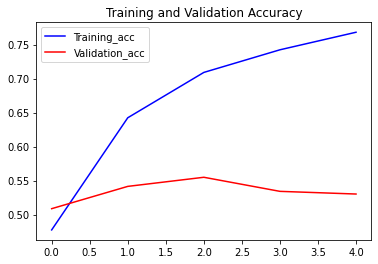

In [30]:
plt.plot(epochs,acc,label='Training_acc',color='blue')
plt.plot(epochs,val_acc,label='Validation_acc',color='red')
plt.legend()
plt.title("Training and Validation Accuracy")
plt.show()

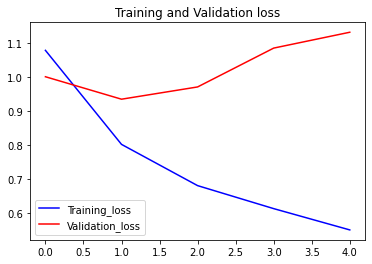

In [31]:
plt.plot(epochs,loss,label='Training_loss',color='blue')
plt.plot(epochs,val_loss,label='Validation_loss',color='red')
plt.legend()
plt.title("Training and Validation loss")
plt.show()

#Classification Report
LSTM model's classification report

*   Report the accuracy, precision, recall, and F1 score of the model on the testing data. Inclue graphs and necessary data. Include this in a markdown cell within the notebook. Compare the basic LSTM model against SOTA and other architectures which you can directly import **(3 points)**

In [32]:
Test.head()

,Polarity,Tweet
0,4,@stellargirl I loooooooovvvvvveee my Kindle2. ...
1,4,Reading my kindle2... Love it... Lee childs i...
2,4,"Ok, first assesment of the #kindle2 ...it fuck..."
3,4,@kenburbary You'll love your Kindle2. I've had...
4,4,@mikefish Fair enough. But i have the Kindle2...


In [33]:
Test['Tweet'] = clean_df(Test['Tweet'])
Test = clean_nulldf(Test)
X_test = model_vec.predict(Test['Tweet'])

16/16 [==============================] - 0s 2ms/step


In [34]:
Test.head()

,Polarity,Tweet
0,4,stellargirl loooooooovvvvvvee kindl not dx coo...
1,4,read kindl love lee child good read
2,4,ok first asses kindl fuck rock
3,4,kenburbari love kindl mine month never look ba...
4,4,mikefish fair enough kindl think perfect


In [35]:
y_pred = model.predict(X_test)

16/16 [==============================] - 1s 12ms/step


In [36]:
y_prediction = []
for y in y_pred:
  y_prediction.append(np.argmax(y))

In [37]:
y_test = list(Test['Polarity'].replace([2,4],[1,2]))

In [38]:
print(classification_report(y_test, y_prediction))

              precision    recall  f1-score   support

           0       0.75      0.53      0.62       177
           1       0.48      0.73      0.58       139
           2       0.71      0.64      0.67       182

    accuracy                           0.62       498
   macro avg       0.65      0.63      0.62       498
weighted avg       0.66      0.62      0.63       498



#Prediction 

*   Use the trained model to predict the sentiment of 25 new tweets with positive (2), neutral (1), or negative (0) **(2 points)**

In [39]:
def sentiment(y_pred):
  sentiment = []
  for y in y_prediction:
    if y == 2:
      s = 'positive'
    elif y == 0:
      s = 'negative'
    else:
      s = 'neutral'
    sentiment.append(s)
  return sentiment

In [40]:
sentiment_LSTM = sentiment(y_prediction)

Sentiment of 25 new tweet data (out of 498) from the above LSTM model 

In [41]:
X_t = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/ML2 Lab 3/testdata.manual.2009.06.14.csv',names=['Polarity','t_id','time','version','user','Tweet'])
X_t.drop(['t_id','time','version','user'],axis=1,inplace=True)

In [42]:
Sentiment_prediction_LSTM = pd.DataFrame(list(zip(list(X_t['Tweet']),list(Test['Tweet']),sentiment_LSTM)),columns=['Tweet','Processed Tweet','Sentiment'])
Sentiment_prediction_LSTM[:25]

,Tweet,Processed Tweet,Sentiment
0,@stellargirl I loooooooovvvvvveee my Kindle2. ...,stellargirl loooooooovvvvvvee kindl not dx coo...,positive
1,Reading my kindle2... Love it... Lee childs i...,read kindl love lee child good read,positive
2,"Ok, first assesment of the #kindle2 ...it fuck...",ok first asses kindl fuck rock,negative
3,@kenburbary You'll love your Kindle2. I've had...,kenburbari love kindl mine month never look ba...,positive
4,@mikefish Fair enough. But i have the Kindle2...,mikefish fair enough kindl think perfect,positive
5,@richardebaker no. it is too big. I'm quite ha...,richardebak big quit happi kindl,positive
6,Fuck this economy. I hate aig and their non lo...,fuck economi hate aig non loan given ass,negative
7,Jquery is my new best friend.,jqueri new best friend,positive
8,Loves twitter,love twitter,positive
9,how can you not love Obama? he makes jokes abo...,not love obama make joke,negative


#SOTA model - Transformer

Transformers provides APIs and tools to easily download and train state-of-the-art pretrained models. Using pretrained models can reduce your compute costs, carbon footprint, and save you the time and resources required to train a model from scratch. These models support common tasks in different modalities, such as:

1. Natural Language Processing: text classification, named entity recognition, question answering, language modeling, summarization, translation, multiple choice, and text generation.
2. Computer Vision: image classification, object detection, and segmentation.
3. Audio: automatic speech recognition and audio classification.
4. Multimodal: table question answering, optical character recognition, information extraction from scanned documents, video classification, and visual question answering.

Resource:<br>
https://huggingface.co/j-hartmann/sentiment-roberta-large-english-3-classes

In [43]:
model_t = pipeline("sentiment-analysis",model="j-hartmann/sentiment-roberta-large-english-3-classes", return_all_scores=True)

Some weights of the model checkpoint at j-hartmann/sentiment-roberta-large-english-3-classes were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [44]:
y_pred_t = model_t(list(Test['Tweet']))

In [46]:
# y_pred_t = y
y_pred_transformer = []
for y in y_pred_t:
  score = []
  # print(y)
  for det in y:
    score.append(det['score'])
  y_pred_transformer.append(np.argmax(np.array(score)))

In [47]:
sentiment_transformer = sentiment(y_pred_transformer)

In [48]:
Sentiment_prediction_transformer = pd.DataFrame(list(zip(list(X_t['Tweet']),list(Test['Tweet']),sentiment_transformer)),columns=['Tweet','Processed Tweet','Sentiment'])
Sentiment_prediction_transformer[:25]

,Tweet,Processed Tweet,Sentiment
0,@stellargirl I loooooooovvvvvveee my Kindle2. ...,stellargirl loooooooovvvvvvee kindl not dx coo...,positive
1,Reading my kindle2... Love it... Lee childs i...,read kindl love lee child good read,positive
2,"Ok, first assesment of the #kindle2 ...it fuck...",ok first asses kindl fuck rock,negative
3,@kenburbary You'll love your Kindle2. I've had...,kenburbari love kindl mine month never look ba...,positive
4,@mikefish Fair enough. But i have the Kindle2...,mikefish fair enough kindl think perfect,positive
5,@richardebaker no. it is too big. I'm quite ha...,richardebak big quit happi kindl,positive
6,Fuck this economy. I hate aig and their non lo...,fuck economi hate aig non loan given ass,negative
7,Jquery is my new best friend.,jqueri new best friend,positive
8,Loves twitter,love twitter,positive
9,how can you not love Obama? he makes jokes abo...,not love obama make joke,negative


Performance of transformer is better than normal LSTM models as can be seen in the below classification report

In [50]:
print(classification_report(y_test, y_pred_transformer))

              precision    recall  f1-score   support

           0       0.87      0.63      0.73       177
           1       0.51      0.95      0.66       139
           2       0.83      0.51      0.63       182

    accuracy                           0.67       498
   macro avg       0.74      0.70      0.67       498
weighted avg       0.75      0.67      0.68       498



In [51]:
gc.collect()

673